
# Analysis of PDFs for PDE, SDE, and Sensor Definitions

 This notebook automates the process of analyzing a set of PDF files for the presence of:
 - Problem Domain Equations (PDE)
 - Solution Domain Equations (SDE)
 - Sensor definitions (both in textual and equation formats)
 
 ## Features
 1. **PDF Text Extraction**: Extracts textual content from PDFs using `pdfplumber`.
 2. **Categorization**: Categorizes each paper based on its content into:
    - PDE-only
    - SDE-only
    - Both PDE and SDE
    - Sensors
    - Neither
 3. **Subcategory Analysis**: Identifies subcategories of PDE, SDE, and sensors based on predefined lists.
 4. **Equation Detection**: Extracts excerpts of equations or formulas from text.
 5. **Data Output**:
    - Generates a summary report saved as a CSV file and a text file in `../results/`.
    - Displays detailed results in a DataFrame.
 6. **Visualization**: Creates bar plots to visualize:
    - Paper categorization
    - Subcategory distribution for PDE, SDE, and sensors
 
 ## Outputs
 - `../results/detailed_analysis_results.csv`: A CSV file with detailed results of the analysis.
 - `../results/summary_report.txt`: A text summary of categorization and subcategory counts.
 
 ## Dependencies
 - `pdfplumber` for PDF text extraction
 - `matplotlib` for visualizations
 - `pandas` for structured data handling
 - `tqdm` for progress bars
 
 ## Instructions
 1. Ensure all required libraries are installed.
 2. Place the PDF files to be analyzed in the specified folder path.
 3. Run the notebook to generate analysis results and visualizations.

In [1]:
import os
import pdfplumber
import re
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load keyword lists from JSON file
with open('../src/keywords.json', 'r') as f:
    keyword_data = json.load(f)

# Extract the lists from the loaded JSON
pde_subcategories = keyword_data['pde_categories']
sde_subcategories = keyword_data['sde_categories']
sensor_subcategories = keyword_data['sensor_categories']

# Initialize counters and dictionaries
paper_categories = {"PDE-only": 0, "SDE-only": 0, "Both PDE and SDE": 0, "Neither": 0, "Sensors": 0}
paper_filenames = {"PDE-only": [], "SDE-only": [], "Both PDE and SDE": [], "Neither": [], "Sensors": []}
pde_subcategory_counts = {subcat: 0 for subcat in pde_subcategories}
sde_subcategory_counts = {subcat: 0 for subcat in sde_subcategories}
sensor_subcategory_counts = {subcat: 0 for subcat in sensor_subcategories}
pde_formulations = []

# Helper functions
def extract_text_from_pdf(pdf_path):
    """Extracts text from a PDF file."""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text = ""
            for page in pdf.pages:
                text += page.extract_text()
        return text
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return ""

def categorize_paper(text):
    """Categorizes the paper into PDE-only, SDE-only, Both, Neither, or Sensors."""
    has_pde = any(re.search(r'\b' + re.escape(subcat) + r'\b', text, re.IGNORECASE) for subcat in pde_subcategories)
    has_sde = any(re.search(r'\b' + re.escape(subcat) + r'\b', text, re.IGNORECASE) for subcat in sde_subcategories)
    has_sensors = any(re.search(r'\b' + re.escape(subcat) + r'\b', text, re.IGNORECASE) for subcat in sensor_subcategories)

    if has_pde and has_sde:
        return "Both PDE and SDE"
    elif has_pde:
        return "PDE-only"
    elif has_sde:
        return "SDE-only"
    elif has_sensors:
        return "Sensors"
    else:
        return "Neither"

def identify_subcategories(text, subcategories):
    """Identifies subcategories in the given text."""
    found_subcategories = []
    for subcat in subcategories:
        if re.search(r'\b' + re.escape(subcat) + r'\b', text, re.IGNORECASE):
            found_subcategories.append(subcat)
    return found_subcategories

# Main analysis function
def analyze_pdfs_in_folder(folder_path):
    """Analyze each PDF in the folder for PDE, SDE, and sensor definitions."""
    results = []
    pdf_files = [file for file in os.listdir(folder_path) if file.endswith(".pdf")]
    for filename in tqdm(pdf_files, desc="Analyzing PDFs"):
        pdf_path = os.path.join(folder_path, filename)

        # Extract text from the PDF
        text = extract_text_from_pdf(pdf_path)

        # Categorize the paper
        category = categorize_paper(text)
        paper_categories[category] += 1
        paper_filenames[category].append(filename)

        # Identify PDE, SDE, and sensor subcategories
        pde_found = identify_subcategories(text, pde_subcategories)
        sde_found = identify_subcategories(text, sde_subcategories)
        sensors_found = identify_subcategories(text, sensor_subcategories)

        # Update subcategory counts
        for subcat in pde_found:
            pde_subcategory_counts[subcat] += 1
        for subcat in sde_found:
            sde_subcategory_counts[subcat] += 1
        for subcat in sensors_found:
            sensor_subcategory_counts[subcat] += 1

        # Extract PDE formulations if found
        equation_excerpts = []
        if pde_found:
            matches = re.findall(r'(\$.*?\$|\b[\w\s]+=[\w\s]+\b)', text)  # Extract LaTeX-like equations or text-based formulas
            equation_excerpts = [match.strip() for match in matches]

        # Store results
        results.append({
            "file": filename,
            "category": category,
            "pde_subcategories": ', '.join(pde_found) if pde_found else 'None',
            "sde_subcategories": ', '.join(sde_found) if sde_found else 'None',
            "sensor_subcategories": ', '.join(sensors_found) if sensors_found else 'None',
            "equation_excerpts": ', '.join(equation_excerpts) if equation_excerpts else 'None'
        })

    return results


# Generate summary report
def generate_summary_report(results):
    """Generates a summary report."""
    # Convert results to DataFrame
    df = pd.DataFrame(results)
    display(df)

    # Save detailed results to a CSV file
    csv_path = '../results/detailed_analysis_results.csv'
    df.to_csv(csv_path, index=False)

    # Save summary counts to a TXT file
    summary_path = '../results/summary_report.txt'
    with open(summary_path, 'w') as summary_file:
        summary_file.write("Paper Categorization Summary:\n")
        for category, count in paper_categories.items():
            summary_file.write(f"{category}: {count}\n")

        summary_file.write("\nPDE Subcategory Counts:\n")
        for subcat, count in pde_subcategory_counts.items():
            summary_file.write(f"{subcat}: {count}\n")

        summary_file.write("\nSDE Subcategory Counts:\n")
        for subcat, count in sde_subcategory_counts.items():
            summary_file.write(f"{subcat}: {count}\n")

        summary_file.write("\nSensor Subcategory Counts:\n")
        for subcat, count in sensor_subcategory_counts.items():
            summary_file.write(f"{subcat}: {count}\n")

    print(f"Summary report saved to {summary_path}")

# Specify folder path
pdf_folder = "/Users/richardpurcell/Dropbox/dal04/PhD/papers/sensors_all/"

# Run the analysis
results = analyze_pdfs_in_folder(pdf_folder)

# Generate summary report
generate_summary_report(results)


Analyzing PDFs: 100%|█████████████████████████| 336/336 [07:24<00:00,  1.32s/it]


,file,category,pde_subcategories,sde_subcategories,sensor_subcategories,equation_excerpts
0,An_Early_Forest_Fire_Detection_System_Based_on...,Sensors,None,None,smart,None
1,WF15090.pdf,Neither,None,None,None,None
2,Research_and_implementation_of_forest_fire_ear...,SDE-only,None,control system,"signal processing, reconfigurable, fusion, dat...",None
3,Forest_Fire_Detection_Using_nRF24L01_Wireless_...,SDE-only,None,machine learning model,None,None
4,Detection_of_forest_fire_using_Dezert-Smaranda...,Sensors,None,None,"fusion, smart",None
...,...,...,...,...,...,...
331,Forest_fire_monitoring_detection_and_decision_...,Neither,None,None,None,None
332,Policy_for_random_aerial_deployment_in_large_s...,Sensors,None,None,intelligent,None
333,Developing_an_efficient_framework_for_real_tim...,Sensors,None,None,"physical parameters, fusion, smart",None
334,Forest_Fire_Detection_using_LoRa_Wireless_Mesh...,Neither,None,None,None,None


Summary report saved to ../results/summary_report.txt


In [2]:
# Visualization function
def generate_visualizations():
    """Generates visualizations for analysis results."""
    # Paper categorization
    plt.figure(figsize=(8, 6))
    plt.bar(paper_categories.keys(), paper_categories.values(), color="skyblue")
    plt.title("Paper Categorization")
    plt.xlabel("Category")
    plt.ylabel("Number of Papers")
    plt.show()

    # PDE subcategory distribution
    plt.figure(figsize=(12, 8))
    plt.barh(list(pde_subcategory_counts.keys()), list(pde_subcategory_counts.values()), color="lightgreen")
    plt.title("PDE Subcategory Distribution", fontsize=18)
    plt.xlabel("Frequency", fontsize=14)
    plt.tight_layout()
    plt.show()

    # SDE subcategory distribution
    plt.figure(figsize=(12, 8))
    plt.barh(list(sde_subcategory_counts.keys()), list(sde_subcategory_counts.values()), color="lightcoral")
    plt.title("SDE Subcategory Distribution", fontsize=18)
    plt.xlabel("Frequency", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Sort the sensor subcategories by frequency in descending order
    sorted_subcategories = sorted(sensor_subcategory_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_keys, sorted_values = zip(*sorted_subcategories)
    
    # Sensor subcategory distribution with sorted bars
    plt.figure(figsize=(12, 8))
    plt.barh(sorted_keys, sorted_values, color="lightblue")
    plt.title("Sensor Subcategory Distribution", fontsize=18)
    plt.xlabel("Frequency", fontsize=14)
    plt.tight_layout()
    plt.show()



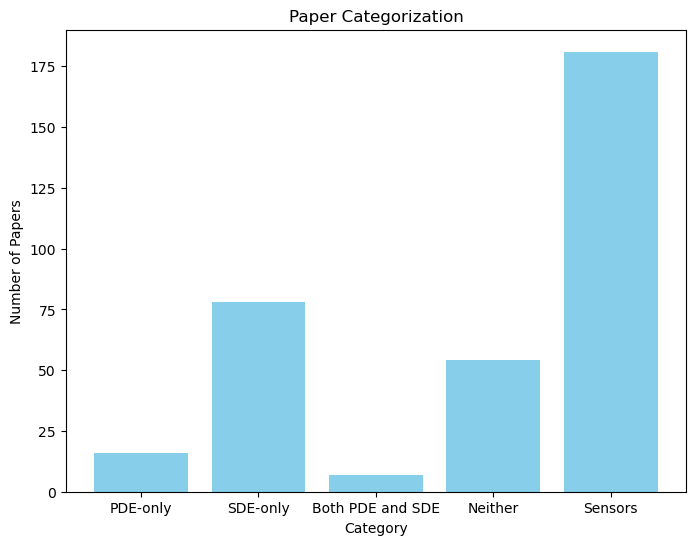

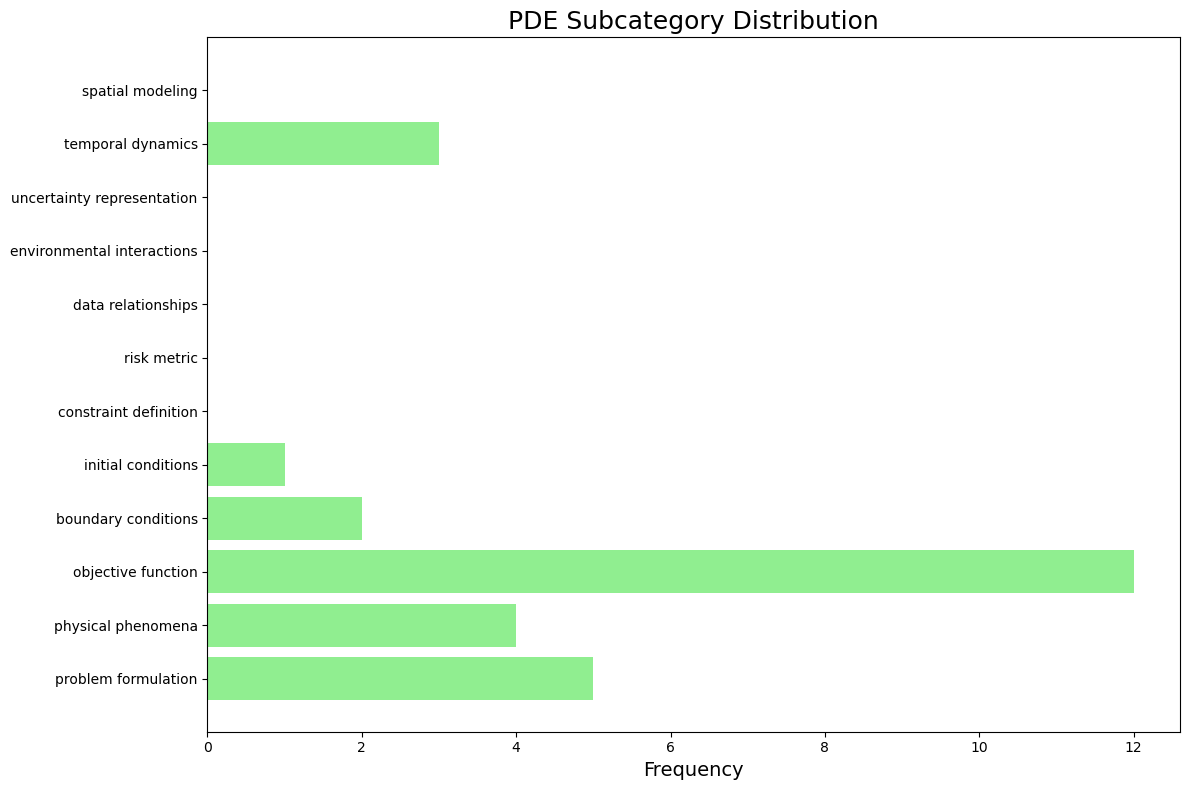

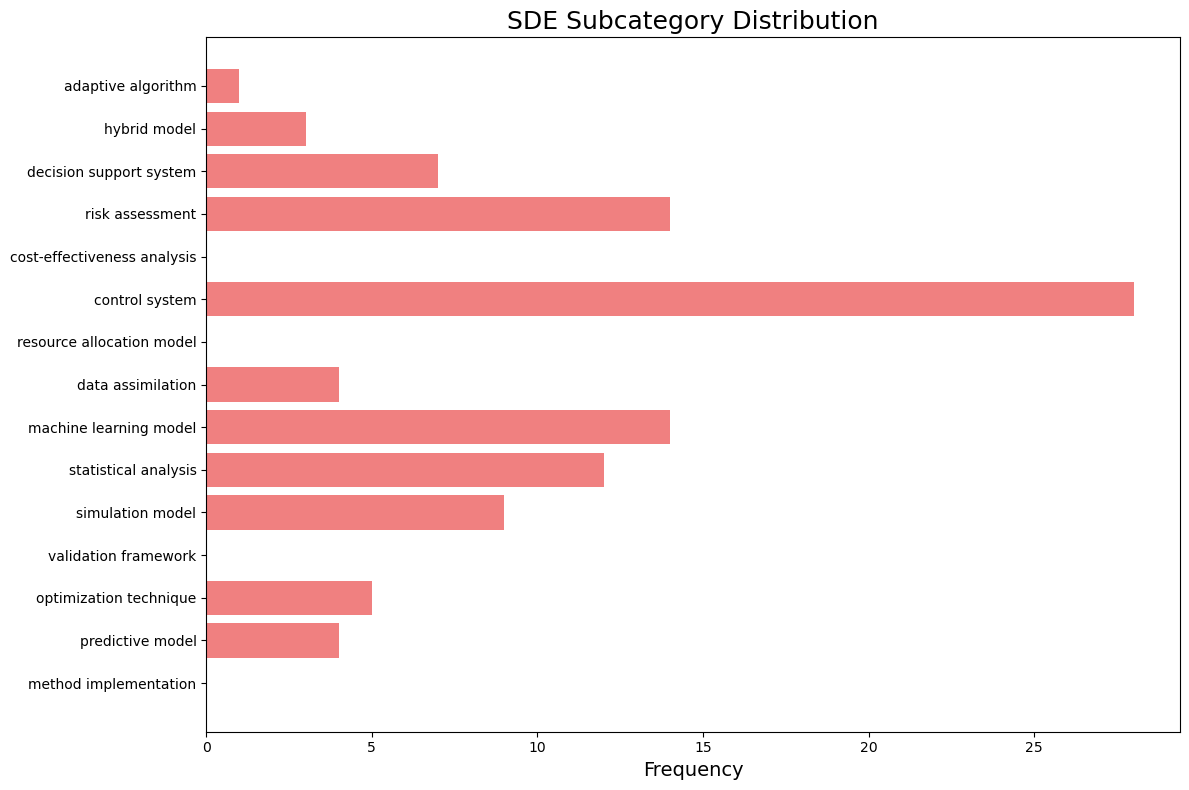

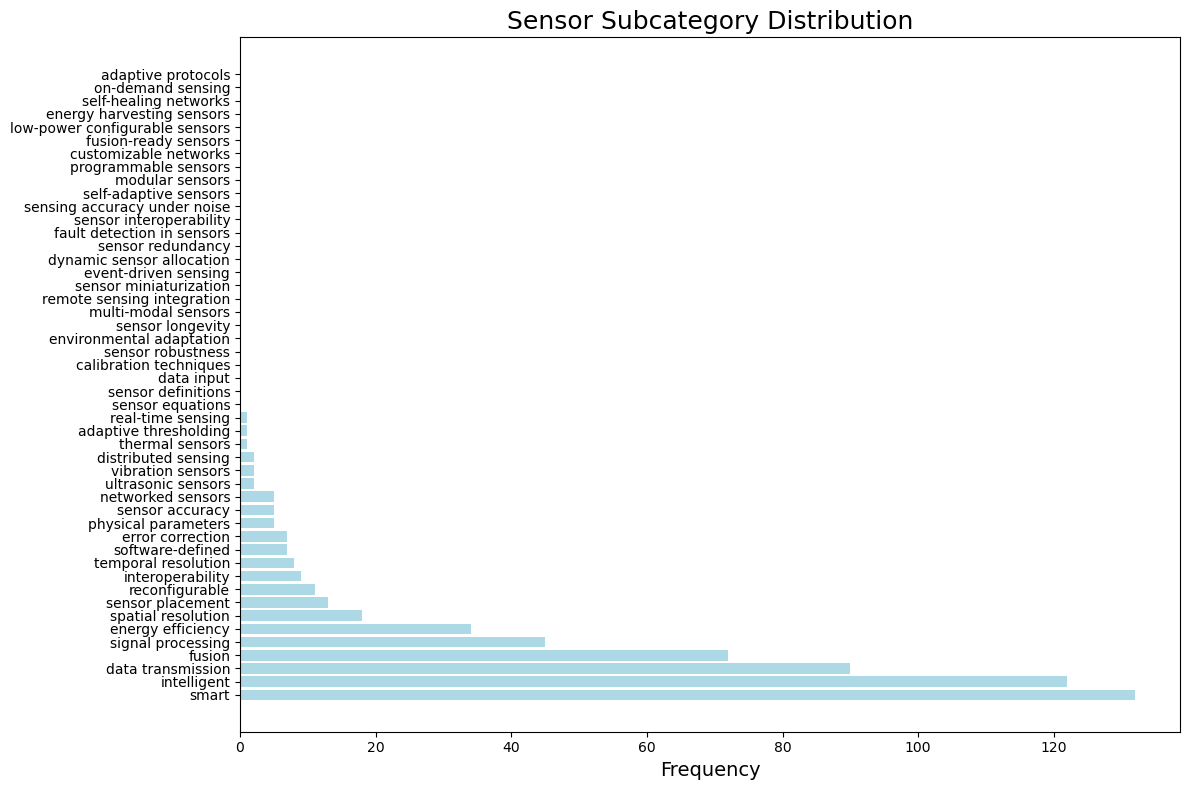

In [3]:
# Generate visualizations
generate_visualizations()